In [1]:
# hide output
%%capture output

! pip install pdfplumber
! pip install chromadb
! pip install pymilvus
! pip install sentence-transformers
! pip install langchain
! pip install pypdf

In [2]:
! pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 22.0 MB/s eta 0:00:00


In [3]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# 1. Load Data

In [4]:
import os
from google.colab import drive
# Access drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Capstone/'


# companies
companies = os.listdir(os.path.join(path, 'Company Reports'))
for i, comp in enumerate(companies):
    print(i, ": ", comp)


# get reports
def get_reports(comp, year:int, rep_type:int = 1):
    """
    comp:       string or index
    year:       specific year or # recent year, 0 for all
    rep_type:   report type, 1 for annual report, 2 for sustainability report, 0 for both
    ret:        list of report pathes
    """
    if type(comp) == str:
        if comp not in companies:
            print("Error: ", comp, " does not exist")
            return
    elif type(comp) == int:
        if comp not in range(len(companies)):
            print("Error: invalid index")
            return
        comp = companies[comp]
    else:
        print("Error: invalid company")
        return

    file_path = os.path.join(path, 'Company Reports', comp)
    files = os.listdir(file_path)
    files.sort(reverse=True)

    years = range(2013,2023)
    if year in range(11):
        if year:
            years = years[-year:]
    else:
        years = [year]

    if rep_type == 0:
        reps = ["", "_sus"]
    elif rep_type == 1:
        reps = [""]
    elif rep_type == 2:
        reps = ["_sus"]
    else:
        print("Error: invalid report type")
        return

    ret = []
    for year in years:
        for rep in reps:
            file = comp + '_' + str(year) + rep + '.pdf'
            if file in files:
                ret.append(file)
    return [os.path.join(file_path, file) for file in ret]

Mounted at /content/drive
0 :  ExxonMobil
1 :  Shell plc
2 :  BP PLC
3 :  Saudi Aramco
4 :  Chevron
5 :  TotalEnergies
6 :  Valero Energy
7 :  Marathon Petroleum Corporation
8 :  Sinopec
9 :  PetroChina


In [11]:
file = get_reports(2, 2022, 1)

file = file[0]
file

'/content/drive/MyDrive/Capstone/Company Reports/BP PLC/BP PLC_2022.pdf'

## 2. Load and Split


In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFium2Loader

loader = PyPDFium2Loader(file)

text_splitter = RecursiveCharacterTextSplitter(
    separators = ["\n\n", " ", "", "."],
    chunk_size = 1000,
    chunk_overlap = 0
)

## 3. Store in Vector database

In [13]:
embeddings = HuggingFaceEmbeddings()

data = text_splitter.split_documents(loader.load())

vs_faiss = FAISS.from_documents(data, embeddings)

## 4. Retrive and Store Relative Contents

Retrieved tables, very hard to do summarization

In [19]:
question = """What is the company's financial performances?"""
financial = vs_faiss.similarity_search(question, k=2)
financial

[Document(page_content='316 720 1,495 — 1,873 193 9,299 \r\nResults of operations for the year ended 31 Decembera\r\nSales and other operating revenuesd\r\nThird parties 549 — 2,101 420 2,977 3,836 — 6,551 1,588 18,022 \r\nSales between businesses 5,747 — 12,746 — 538 2,146 — 9,932 1,472 32,581 \r\n 6,296 — 14,847 420 3,515 5,982 — 16,483 3,060 50,603 \r\nExploration expenditure 11 — 144 109 172 57 — 94 (2) 585 \r\nProduction costs 498 — 2,102 83 327 592 — 723 107 4,432 \r\nProduction taxes 1 — 194 — 513 — — 1,544 73 2,325 \r\nOther costs (income)e\r\n (210) (47) 2,926 63 96 206 32 (44) 300 3,322 \r\nDepreciation, depletion and amortization 1,242 — 3,122 18 680 2,075 1 2,495 384 10,017 \r\nNet impairments and (gains) losses on sale of \r\nbusinesses and fixed assetsf\r\n (433) (901) 217 (3) 1,570 (1,189) 1,523 (341) (43) 400 \r\n 1,109 (948) 8,705 270 3,358 1,741 1,556 4,471 819 21,081 \r\nProfit (loss) before taxationg\r\n 5,187 948 6,142 150 157 4,241 (1,556) 12,012 2,241 29,522 \r\n

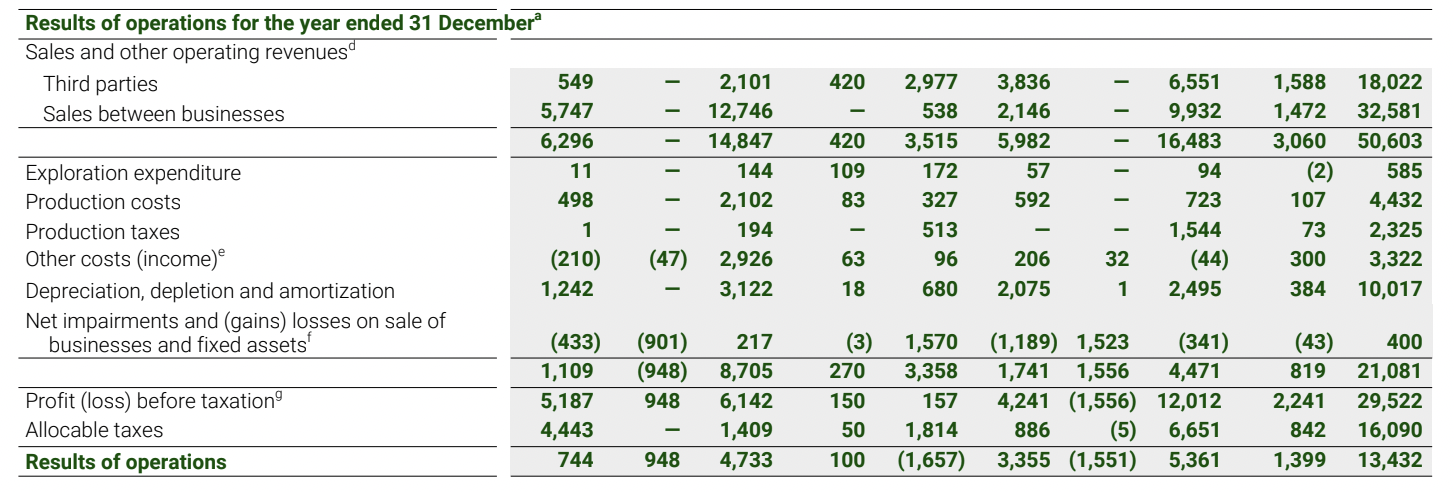

In [15]:
question = """What is the company's market position and competition?"""
position = vs_faiss.similarity_search(question, k=2)
position

[Document(page_content='Cross reference to Form 20-F\r\nPage\r\nItem 1. Identity of Directors, Senior Management and Advisers n/a\r\nItem 2. Offer Statistics and Expected Timetable n/a\r\nItem 3. Key Information\r\nA. [Reserved] n/a\r\nB. Capitalization and indebtedness n/a\r\nC. Reasons for the offer and use of proceeds n/a\r\nD. Risk factors 73-75\r\nItem 4. Information on the Company\r\nA. History and development of the company 3, 31, 32-44, 206-208, 214, 220, 222-224, 358-368, 383, 387, 403\r\nB. Business overview 3, 6-9, 10-19, 32-44, 209-213, 358-373, 378\r\nC. Organizational structure 262, 403\r\nD. Property, plants and equipment 22, 41-42, 219-220, 288-290, 358-369, 374\r\nItem 4A. Unresolved Staff Comments None\r\nItem 5. Operating and Financial Review and Prospects\r\nA. Operating results 3, 6-9, 10-19, 24-25, 32-44, 122-124, 222-226, 235, 237-249, 358-368, 373-374\r\nB. Liquidity and capital resources 183-184, 220, 235-236, 237-249, 356-357\r\nC. Research and development, pa

In [20]:
question = """What are the company's strategic initiatives?"""
strategy = vs_faiss.similarity_search(question, k=2)
strategy

[Document(page_content='with shareholders, the workforce and other \r\nstakeholders, page 91.\r\nOur strategy and business model, pages 10-14. \r\nSustainability: ethics and compliance, page 68. \r\nSustainability: our values and code of conduct, page 66.\r\nImpact of operations on the community and the environment. Sustainability: caring for our planet, page 64. \r\nSustainability: safety, page 65.\r\nMaintaining a reputation for high standards of business conduct. Role of the board, page 87.\r\nSustainability: ethics and compliance, page 68. \r\nSustainability: our values and code of conduct, page 66.\r\nActing fairly between members of the company. How the board has engaged with shareholders, the workforce and other \r\nstakeholders, page 91.\r\nDetails of three key decisions that were taken by \r\nthe board in the past year in the context of the \r\nframework are set out on page 90.', metadata={'source': '/content/drive/MyDrive/Capstone/Company Reports/BP PLC/BP PLC_2022.pdf', 'pag

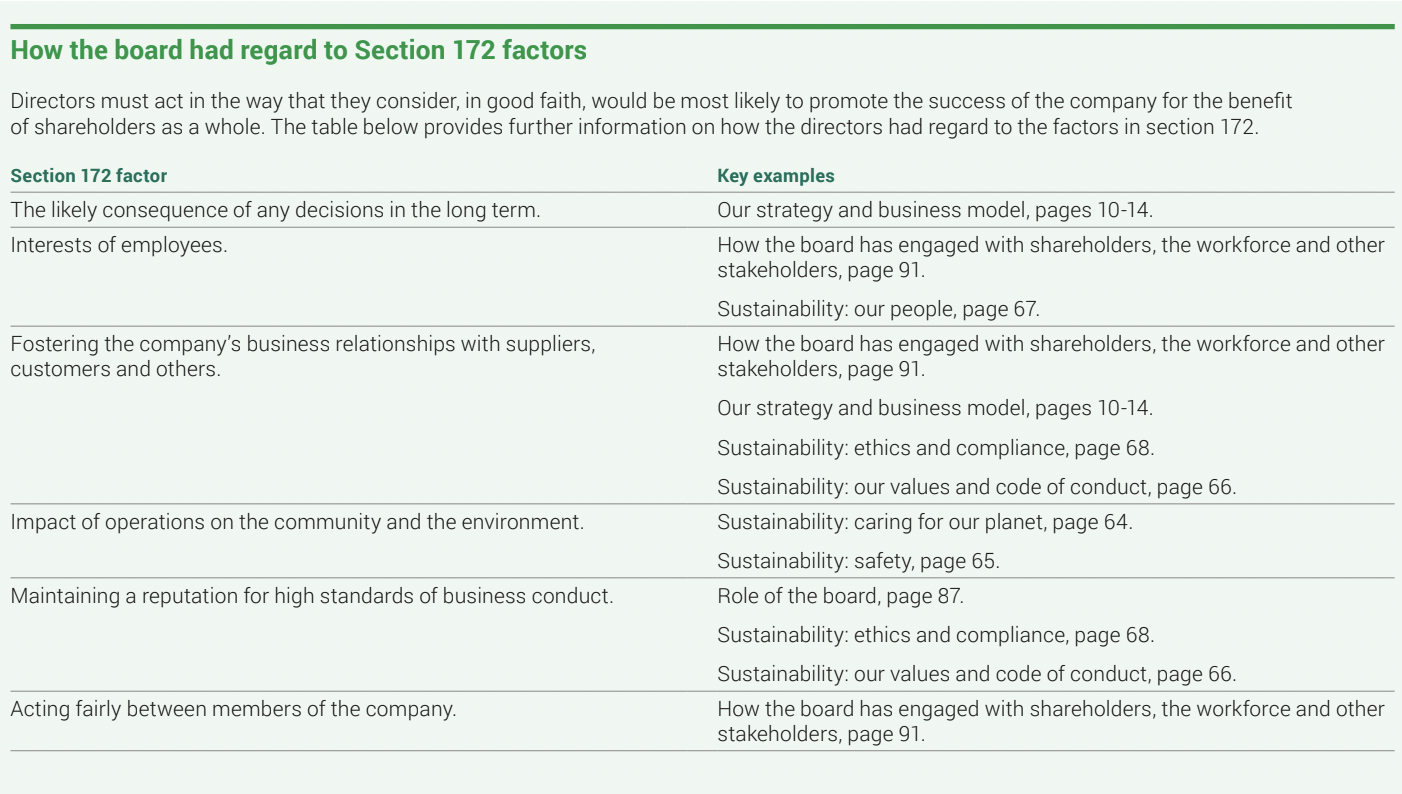

In [16]:
question = """What are the challenges the company faces?"""
challenges = vs_faiss.similarity_search(question, k=2)
challenges

[Document(page_content='company \r\nto an integrated energy company, we face an \r\nexpanded and rapidly evolving range of \r\ncompetitors in the sectors in which we operate. \r\nWe could be adversely affected if competitors \r\noffer superior terms for access rights or licences, \r\nor if our innovation in areas such as new low \r\ncarbon technologies, digital, customer offer, \r\nexploration, production, refining, manufacturing \r\nor renewable energy lags behind those of our \r\ncompetitors. Our performance could also be \r\nnegatively impacted if we fail to protect our \r\nintellectual property. \r\nTalent and capability: inability to attract, \r\ndevelop and retain people with necessary skills \r\nand capabilities could negatively impact delivery \r\nof our strategy. \r\nThe sectors in which we operate face increasing \r\nchallenges to attract and retain diverse, skilled \r\nand capable talent. An inability to successfully \r\nrecruit, develop and retain core skills and \r\ncapabi

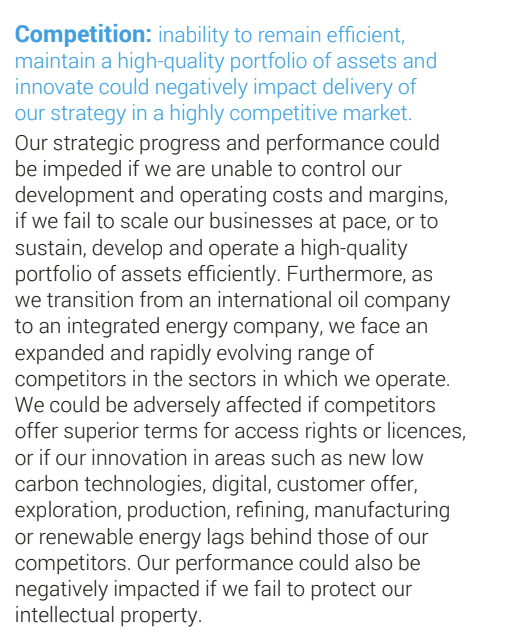

## 5. Model T-5

In [ ]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, pipeline, AutoModelForSeq2SeqLM

model_id = 'google/flan-t5-xxl'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipe = pipeline(
    "text2text-generation",
    model = model,
    tokenizer = tokenizer,
    max_length = 2000
)

llm = HuggingFacePipeline(pipeline = pipe)

## 6. Result

### Financial

In [31]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate

prompt = """Summarize the performance of the company in complete sentences: /n {text} /n SUMMARY:"""
prompt_template = PromptTemplate(template=prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='stuff',
                                     prompt=prompt_template)

output = summary_chain.run(financial)
output

'The company reported a loss of $1.2 billion for the year ended 31 December.'

In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate

map_prompt = """Summarize the achievement of the company in complete sentences: /n {text} /n SUMMARY:"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

combine_prompt = """Generate a structured summary of the company's achievement: /n {text} /n SUMMARY:"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template)

output = summary_chain.run(financial)

In [25]:
output

'The company reported a net loss of $ 316 million for the year ended 31 December.'

### Strategy

In [29]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate

prompt = """Summarize the strategy of the company in complete sentences: /n {text} /n SUMMARY:"""
prompt_template = PromptTemplate(template=prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='stuff',
                                     prompt=prompt_template)

output = summary_chain.run(strategy)
output

'bp Annual Report and Form 20-F 2022 Our strategy and business model, pages 10-14. Sustainability: ethics and compliance, page 68. Sustainability: our values and code of conduct, page 66. Impact of operations on the community and the environment. Sustainability: caring for our planet, page 64. Sustainability: safety, page 65. Maintaining a reputation for high standards of business conduct. Role of the board, page 87. Sustainability: ethics and compliance, page 68. Sustainability: our values and code of conduct, page 66. Acting fairly between members of the company. How the board has engaged with shareholders, the workforce and other stakeholders, page 91. Details of three key decisions that were taken by the board in the past year in the context of the framework are set out on page 90. 13 Strategic report See glossary on page 389 bp Annual Report and Form 20-F 2022 Our business groups This is how we are organized to deliver our strategy and grow long-term shareholder value. Our three b

In [35]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate

map_prompt = """Summarize the strategy of the company in complete sentences: /n {text} /n SUMMARY:"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

combine_prompt = """Generate a structured summary of the company's strategy: /n {text} /n SUMMARY:"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template)

output = summary_chain.run(strategy)

In [36]:
output

'The board has a responsibility to ensure that the company is managed in a way that is fair to all its stakeholders.'

### Challenges

In [30]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate

prompt = """Summarize the challenges of the company in complete sentences: /n {text} /n SUMMARY:"""
prompt_template = PromptTemplate(template=prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='stuff',
                                     prompt=prompt_template)

output = summary_chain.run(challenges)
output

'Competition: as we transition from an upstream oil and gas'

In [33]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate

map_prompt = """Summarize the challenges of the company in complete sentences: /n {text} /n SUMMARY:"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

combine_prompt = """Generate a structured summary of the company's challenges: /n {text} /n SUMMARY:"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template)

output = summary_chain.run(challenges)

In [34]:
output

'Competition: as we move from an upstream oil and gas'